In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

# Example 1 : discovering the Lindblad equation \[[source](https://qutip.org/docs/latest/guide/dynamics/dynamics-master.html)\]

## `qutip.sesolve`

In [2]:
H = 2*np.pi * 0.1 * sigmax()

psi0 = basis(2, 0)

times = np.linspace(0.0, 10.0, 20)

result = sesolve(H, psi0, times, [sigmaz()])

result

Result object with sesolve data.
--------------------------------
expect = True
num_expect = 1, num_collapse = 0

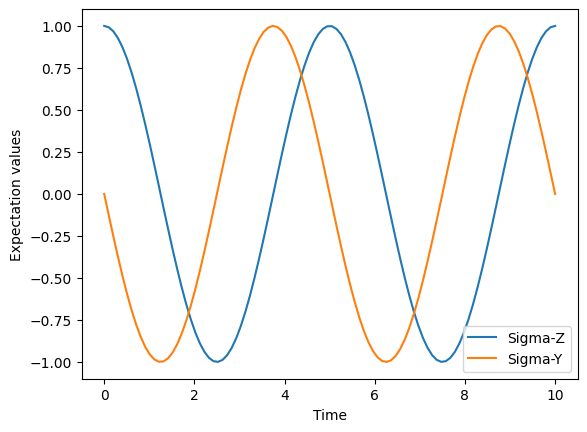

In [3]:
H = 2*np.pi * 0.1 * sigmax()

psi0 = basis(2, 0)

times = np.linspace(0.0, 10.0, 100)

result = sesolve(H, psi0, times, [sigmaz(), sigmay()])

fig, ax = plt.subplots()

ax.plot(result.times, result.expect[0]) 

ax.plot(result.times, result.expect[1]) 

ax.set_xlabel('Time') 

ax.set_ylabel('Expectation values') 

ax.legend(("Sigma-Z", "Sigma-Y")) 

plt.show() 


## `qutip.mesolve`

same idea as `sesolve`, same arguments except 4th argument is collapse operators and 5th arg is now the op we want to take the expectation of.

we use $A = \sigma_x$ and $\gamma = 0.05$ for the collapse operator. How'd we find this ? 

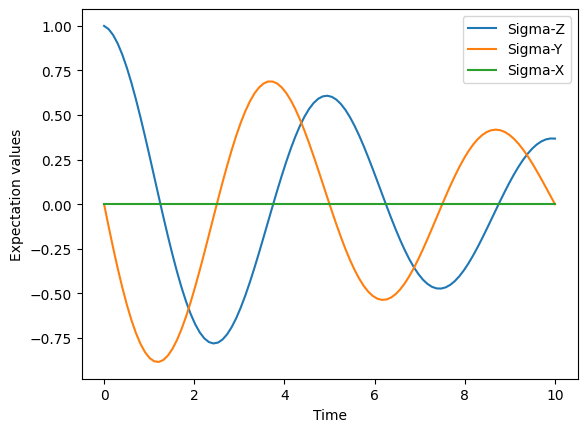

In [4]:
times = np.linspace(0.0, 10.0, 100)

result = mesolve(H, psi0, times, [np.sqrt(0.05) * sigmax()], [sigmaz(), sigmay(), sigmax()])

fig, ax = plt.subplots()

ax.plot(times, result.expect[0]) 

ax.plot(times, result.expect[1]) 

ax.plot(times, result.expect[2]) 

ax.set_xlabel('Time') 

ax.set_ylabel('Expectation values') 

ax.legend(("Sigma-Z", "Sigma-Y", "Sigma-X"))  

plt.show() 

## Leaky cavity

a 2-level atom in its ground state coupled to a 10-level cavity in a 5-photon state.

Hamiltonian is : 

$$H = 2\pi \left(a^{\dagger}a + \sigma^+ \sigma^- + g \left(\sigma^+ a^{\dagger} + \sigma^- a \right)\right)$$

with $a, a^{\dagger}$ the ladder operators of the cavity, $\sigma^-,\sigma^+$ the ladder operators of the atom, and $g = 0.5$ the coupling constant.

The cavity is the leaky mode so we use $a$ as a collapse operator. We also run the simulation looking at expectations values of the number operators of both the cavity and the atom.

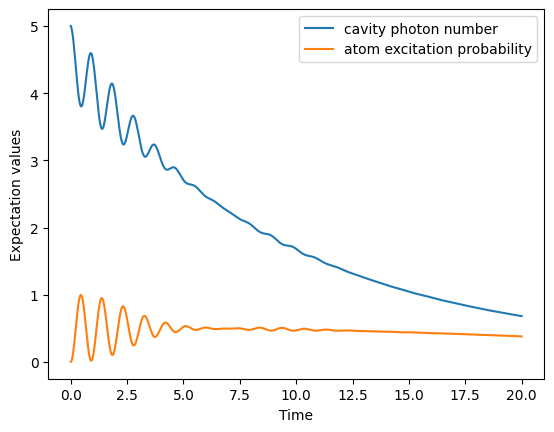

In [5]:
times = np.linspace(0.0, 20.0, 2001)

psi0 = tensor(fock(2,0), fock(10, 5))

a  = tensor(qeye(2), destroy(10))

sm = tensor(destroy(2), qeye(10))

H = 2 * np.pi * a.dag() * a + 2 * np.pi * sm.dag() * sm + 2 * np.pi * 0.25 * (sm * a.dag() + sm.dag() * a)

result = mesolve(H, psi0, times, [np.sqrt(0.1)*a], [a.dag()*a, sm.dag()*sm]) # 

plt.figure() 

plt.plot(times, result.expect[0]) 

plt.plot(times, result.expect[1]) 

plt.xlabel('Time') 

plt.ylabel('Expectation values') 

plt.legend(("cavity photon number", "atom excitation probability")) 

plt.show() 


# Example 2 : Time-resolved excitations \[[source](https://qutip.org/docs/latest/guide/dynamics/dynamics-time.html)\]

## Implementing time-dependent operators

There are **three ways to do it** :
- Expressing the operators as a `[QObj, func]` pair where `func` is a Python function giving the time dependence. **easy but only as fast as Python**
- Same thing but `func` is a string containing C code. **faster but a bit harder**
- Just giving a list of operators, one for each entry in the list of time points of the simulation. The simulation will interpolate the operators in between time steps.

## Time-dependent coupling

$$H = H_0 - f(t)H_1$$
(where $f(t) = \exp{\left(-\left(\frac{t}{\sigma}\right)^2\right)}$.)

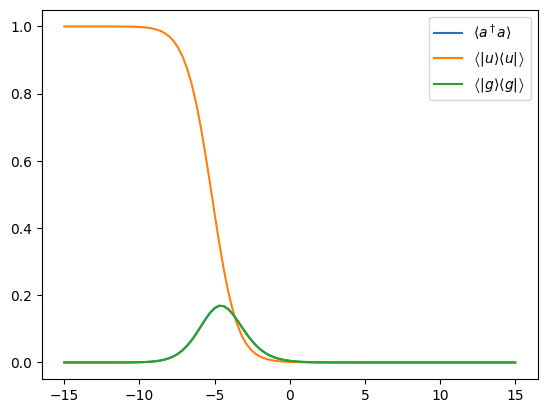

In [6]:
# setting up a three-state system
ustate = basis(3, 0)
excited = basis(3, 1)
ground = basis(3, 2)

N = 2 # Set where to truncate Fock state for cavity
sigma_ge = tensor(qeye(N), ground * excited.dag())  # |g><e|
sigma_ue = tensor(qeye(N), ustate * excited.dag())  # |u><e|
a = tensor(destroy(N), qeye(3))
ada = tensor(num(N), qeye(3))

c_ops = []  # Build collapse operators
kappa = 1.5 # Cavity decay rate
c_ops.append(np.sqrt(kappa) * a)
gamma = 6  # Atomic decay rate
c_ops.append(np.sqrt(5*gamma/9) * sigma_ue) # Use Rb branching ratio of 5/9 e->u
c_ops.append(np.sqrt(4*gamma/9) * sigma_ge) # 4/9 e->g

t = np.linspace(-15, 15, 100) # Define time vector
psi0 = tensor(basis(N, 0), ustate) # Define initial state

state_GG = tensor(basis(N, 1), ground) # Define states onto which to project
sigma_GG = state_GG * state_GG.dag()
state_UU = tensor(basis(N, 0), ustate)
sigma_UU = state_UU * state_UU.dag()

g = 5  # coupling strength
H0 = -g * (sigma_ge.dag() * a + a.dag() * sigma_ge)  # time-independent term
H1 = (sigma_ue.dag() + sigma_ue)  # time-dependent term

def H1_coeff(t, args):
    return 9 * np.exp(-(t / 5.) ** 2)

H = [H0,[H1, H1_coeff]]
output = mesolve(H, psi0, t, c_ops, [ada, sigma_UU, sigma_GG])

fig, ax = plt.subplots()

ax.plot(t, output.expect[0], label = r'$\left\langle a^\dagger a\right\rangle$')
ax.plot(t, output.expect[1], label = r'$\left\langle \left| u\right\rangle\left\langle u\right|\right\rangle$')
ax.plot(t, output.expect[2], label = r'$\left\langle \left| g\right\rangle\left\langle g\right|\right\rangle$')
ax.legend()

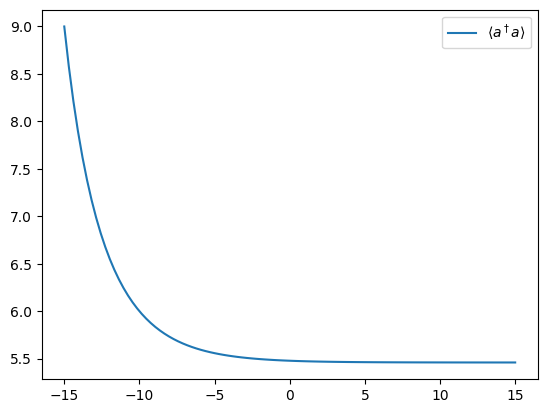

In [7]:
kappa = 0.5

def col_coeff(t, args):  # coefficient function
    return np.sqrt(kappa * np.exp(-t))

N = 10  # number of basis states
a = destroy(N)
H = a.dag() * a  # simple HO
psi0 = basis(N, 9)  # initial state
c_ops = [[a, col_coeff]]  # time-dependent collapse term
times = np.linspace(0, 10, 100)
output = mesolve(H, psi0, times, c_ops, [a.dag() * a])

fig, ax = plt.subplots()

ax.plot(t, output.expect[0], label = r'$\left\langle a^\dagger a\right\rangle$')
ax.legend()


# Tinkering with correlation functions

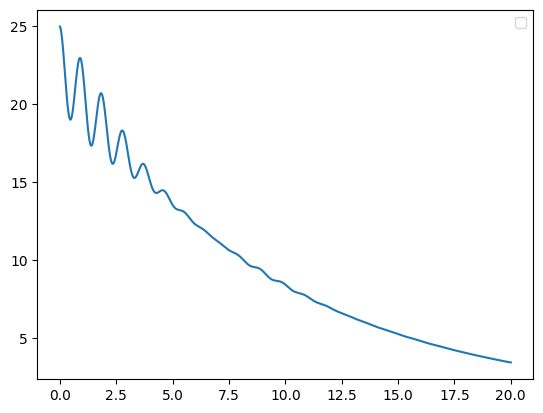

In [28]:
t = np.linspace(0.0, 20.0, 2001)

psi0 = tensor(fock(2,0), fock(10, 5))

a  = tensor(qeye(2), destroy(10))
ada = a.dag()*a

sm = tensor(destroy(2), qeye(10))

H = 2 * np.pi * a.dag() * a + 2 * np.pi * sm.dag() * sm + 2 * np.pi * 0.25 * (sm * a.dag() + sm.dag() * a)
c_ops = [np.sqrt(0.1)*a]

result = mesolve(H, psi0, times, c_ops, [a.dag()*a, sm.dag()*sm]) 

corr1 = correlation_2op_1t(H, psi0, t, c_ops, ada, ada)



fig, ax = plt.subplots()
ax.plot(t, np.real(corr1))
ax.legend()

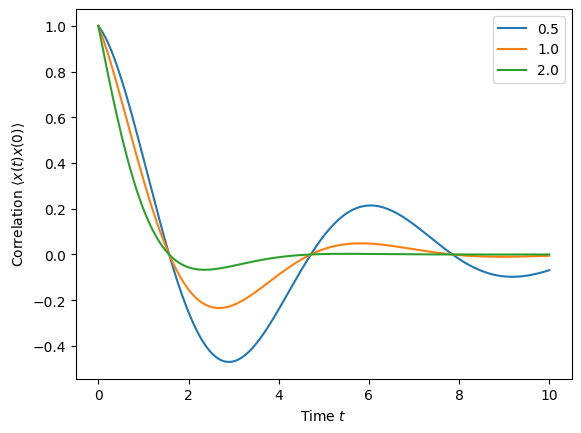

In [10]:
times = np.linspace(0,10.0,200)
a = destroy(10)
x = a.dag() + a
H = a.dag() * a

corr1 = correlation_2op_1t(H, None, times, [np.sqrt(0.5) * a], x, x)
corr2 = correlation_2op_1t(H, None, times, [np.sqrt(1.0) * a], x, x)
corr3 = correlation_2op_1t(H, None, times, [np.sqrt(2.0) * a], x, x)

plt.figure()
plt.plot(times, np.real(corr1), times, np.real(corr2), times, np.real(corr3))
plt.legend(['0.5','1.0','2.0'])
plt.xlabel(r'Time $t$')
plt.ylabel(r'Correlation $\left<x(t)x(0)\right>$')
plt.show()


# Complete setup
## Time-independent hamiltonian

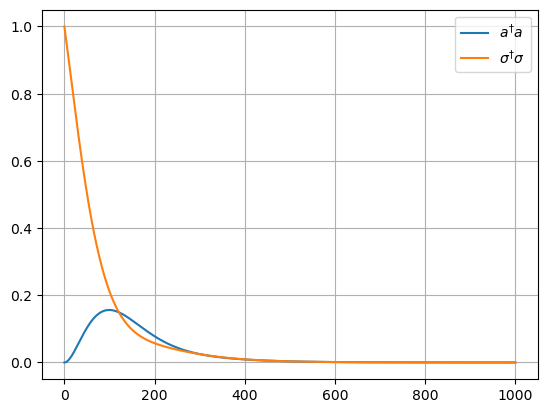

In [21]:
g = 1e-2
delta_o = 0
delta_c = 0
kappa = 1e-1
gamma = 1e-1

times = np.linspace(0, 1000, 1001)

sigma = tensor(destroy(2), qeye(2)) # atom annihilation operator
a = tensor(qeye(2), destroy(2)) # cavity annihilation operator

n_a = a.dag()*a
n_sigma = sigma.dag()*sigma

H = delta_o*n_a + delta_c*n_sigma + g*(a.dag()*sigma + a*sigma.dag())

psi0 = tensor(fock(2, 1),fock(2, 0))

c_ops = [kappa*a, 2*gamma*n_sigma, gamma*sigma]

result = mesolve(H, psi0, times, c_ops, [n_a, n_sigma])

labels = [r"$a^{\dagger}a$", r"$\sigma^{\dagger}\sigma$"]

for i, out in enumerate(result.expect) :
    plt.plot(times, out, label=labels[i])

plt.grid(True)
plt.legend()


## Time-dependent part

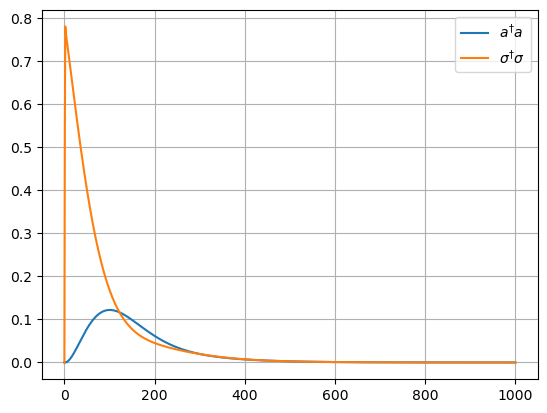

In [41]:
H_t = 0.5*(sigma + sigma.dag())

def Omega(t, args):
    sigma = args["width"]
    mu = args["delay"]
    A = args["amp"]
    return A/(sigma*np.sqrt(2*np.pi)) * np.exp(-((t-mu)/sigma)**2/2)

complete_H = [H, [H_t, Omega]]

psi0 = tensor(fock(2, 0), fock(2, 0))

purcell = 4*g/(gamma*kappa)
pulse_width = 1/(10*purcell*gamma)

omega_args = {"width" : pulse_width,
              "delay": 5*pulse_width,
              "amp": 10.4,}

result = mesolve(complete_H, psi0, times, c_ops, [n_a, n_sigma], args=omega_args)

labels = [r"$a^{\dagger}a$", r"$\sigma^{\dagger}\sigma$"]

for i, out in enumerate(result.expect) :
    plt.plot(times, out, label=labels[i])

plt.grid(True)
plt.legend()


## Getting figures of merit


mu = 2.23e+00, purcell expre = 8.00e-01
 g² = 7.85e-05


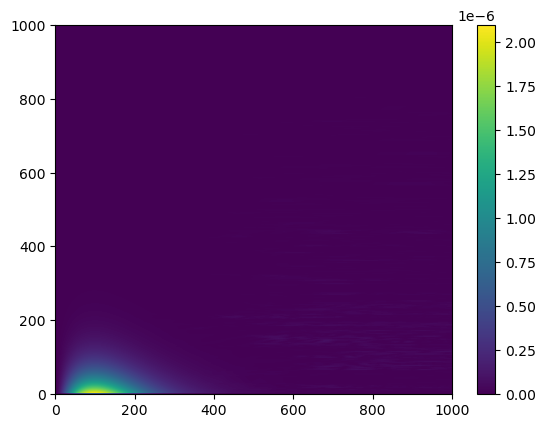

In [42]:
dt = times[1] - times[0]

n_a_sims = result.expect[0] # list of <a^dag a> over time

mu = kappa*np.sum(n_a_sims)*dt

g2_integrand = correlation_3op_2t(complete_H, psi0, times, times, c_ops, a.dag(), n_a, a, solver='me', args=omega_args)

g2 = np.real(2*kappa**2/mu**2 * np.sum(g2_integrand)*dt**2)

plt.imshow(np.abs(g2_integrand), origin = "lower", aspect = "auto")
plt.colorbar()

print(f"mu = {mu:.2e}, purcell expre = {purcell/(1 + purcell):.2e}\n g² = {g2:.2e}")